In [56]:
import keras as keras
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, BatchNormalization
from keras.initializers import glorot_uniform
from keras.initializers import Constant
from keras.utils import to_categorical
from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.datasets import cifar10, mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Resizing, RandomCrop, RandomFlip, RandomRotation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import math
from IPython.display import Image

##### VGGNet : 매우 단순하고 고전적인 구조

###### GoogLenet

> * 1x1의 장점 <br> 
channel수 조절 <br>
연산량 감소(Effcient) <br>
비선형성(Non-Lineartiy)

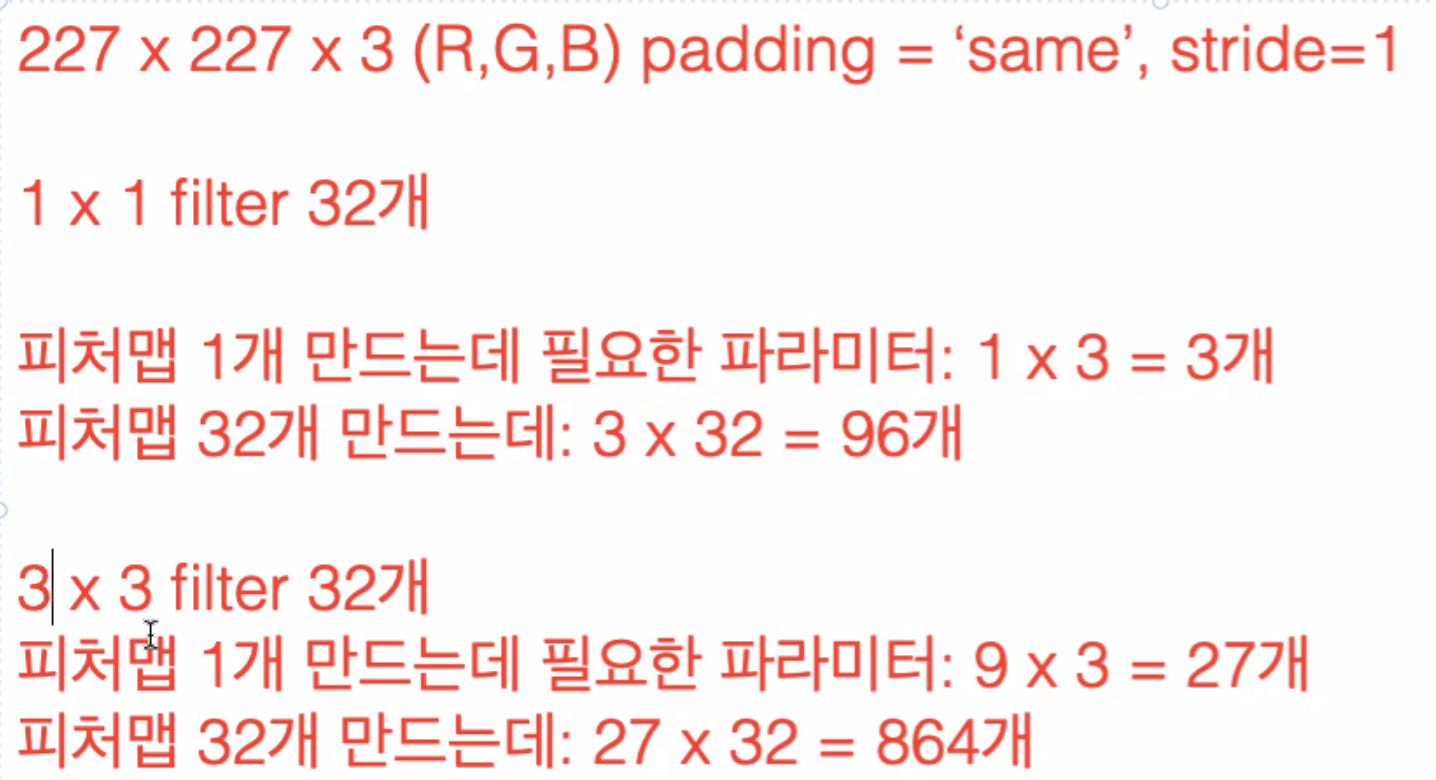

In [3]:
Image('./JupyterImage/221206/GoogLeNet.png')

## Data Load

In [53]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ti = x_train[0]
print(ti.shape)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

def augmentattion(x_train, y_train, resizing) :
    
    model = Sequential([Rescaling(1/255.),
                        resizing,
                       RandomCrop(32,32), # 32 X 32로 조정되어 중심축이 변경되며 일부가 잘려진다.
                       RandomFlip('horizontal'),
                       RandomRotation(np.random.randint(0,360))])

    Model.build(model, (1, ti.shape[0], ti.shape[1], 3)) # 3차원
    
    globals()[f"x_train_2"] = model(x_train)
                
    # 데이터 결합
    globals()[f"x_train_all"] = np.concatenate((x_train, x_train_2), axis=0) 
    globals()[f"y_train_all"] = np.concatenate((y_train, y_train), axis=0)
    
    
    
resizing = Resizing(int(ti.shape[0]*1.1), int(ti.shape[1]*1.1)) 
augmentattion(x_train, y_train, resizing)

(32, 32, 3)
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


2022-12-06 14:28:36.455492: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/branch_executed/_9


In [ ]:
num_classes = 10

def load_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

X_train, y_train, X_test, y_test = load_cifar10_data(224, 224)

# GooglLeNet 생성

In [32]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [33]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', 
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', 
                       kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

# Official

/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


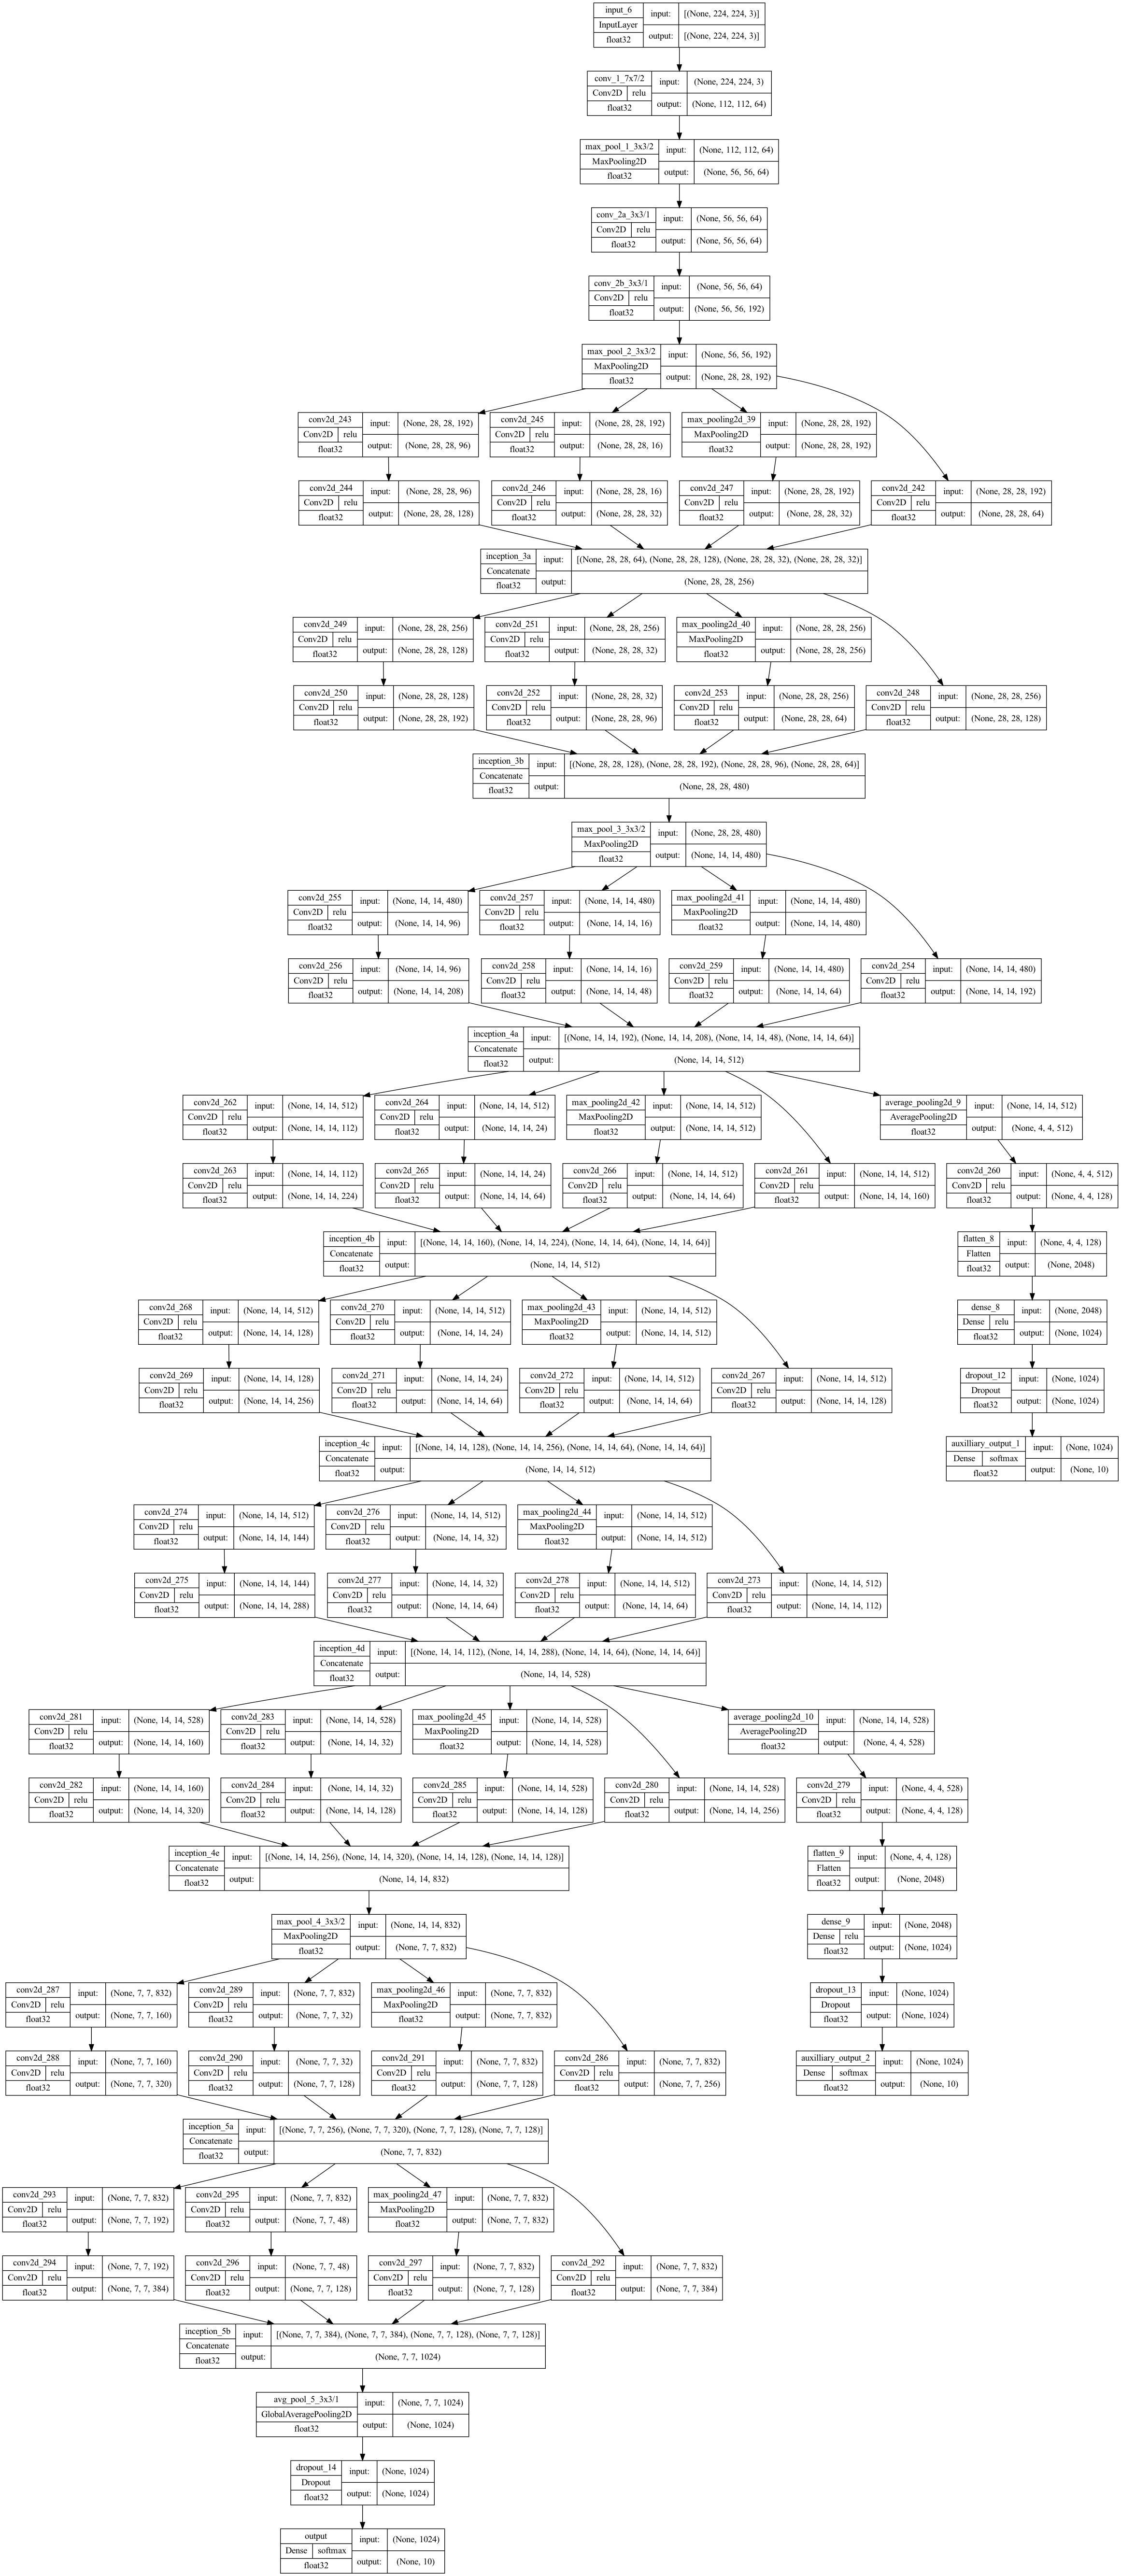

In [54]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

model1 = Model(input_layer, [x, x1, x2], name='inception_v1')

plot_model(model1, show_shapes=True, show_dtype=True, show_layer_activations=True)

### user made

#### model3

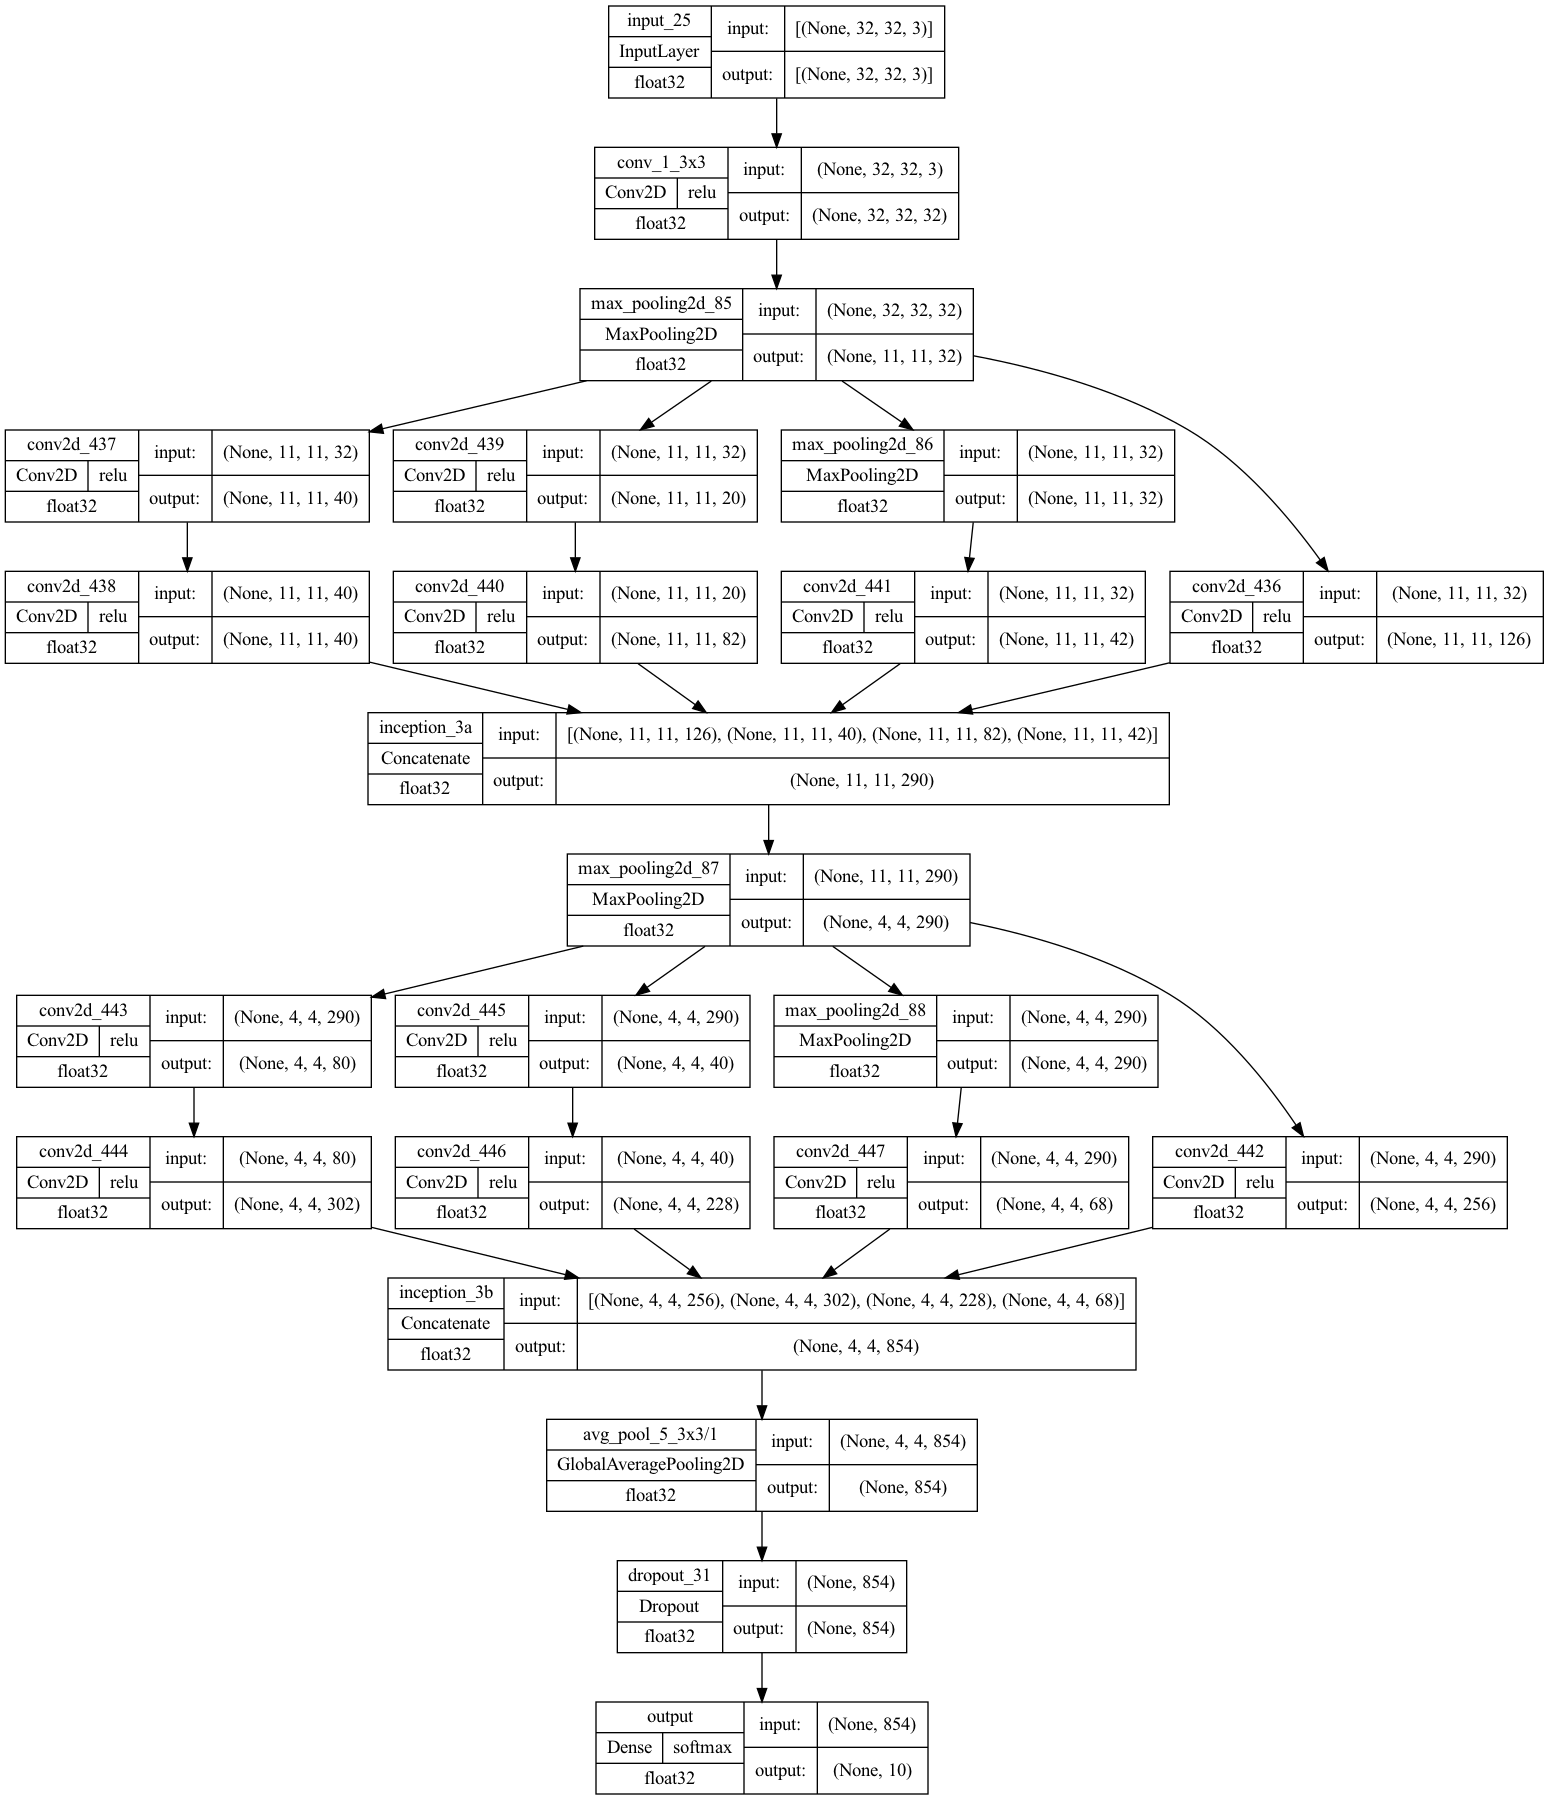

In [130]:
input_layer = Input(x_train_all.shape[1:])

x = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_1_3x3', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
# x = BatchNormalization(name="BNM1")(x)
x = MaxPool2D((2, 2), strides=3)(x)
x = inception_module(x,
                     filters_1x1=126,
                     filters_3x3_reduce=40,
                     filters_3x3=40,
                     filters_5x5_reduce=20,
                     filters_5x5=82,
                     filters_pool_proj=42,
                     name='inception_3a')
x = MaxPool2D((2, 2), strides=3)(x) 
x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=80,
                     filters_3x3=302,
                     filters_5x5_reduce=40,
                     filters_5x5=228,
                     filters_pool_proj=68,
                     name='inception_3b')
x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
# x = Flatten()(x)
x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

model4 = Model(input_layer, x, name='inception_user1')

plot_model(model4, show_shapes=True, show_dtype=True, show_layer_activations=True)

In [83]:
model2.summary()

Model: "inception_user1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_1_3x3 (Conv2D)            (None, 32, 32, 32)   896         ['input_18[0][0]']               
                                                                                                  
 max_pooling2d_62 (MaxPooling2D  (None, 10, 10, 32)  0           ['conv_1_3x3[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_359 (Conv2D)            (None, 10, 10, 64)   2112        ['max_pooling2d_62[

In [84]:
x_train_all[0].shape

(32, 32, 3)

In [117]:
class MyCallback(Callback):
    def on_epoch_end(self, end, logs={}):
        if logs.get('val_acc') > 0.95:
            self.model.stop_training = True
            print('\n')
            print('목표 정확도 달성: 검증 정확도 %.4f' % logs.get('val_acc'))
my_callback = MyCallback()



def mdFit(model, num, X_train, y_train, my_callback) : # + best model select.

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', #No OneHot Encoding
              metrics=['acc'])
    model.summary()
       
    best_model_path = f"./bestModel/LeNet5/best_cnn_model{num}.h5" 
    save_best_model = ModelCheckpoint(best_model_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=False)

    globals()[f'hist{num}'] = model.fit(
        x=X_train, y=y_train, batch_size=128, epochs=20, verbose=1,
        validation_split=0.2, callbacks=[my_callback ,save_best_model]) 
    # validation : (x_test, y_test)값을 가지고 와서 봐도 된다. 현재 0.2의 비율로 가져와서
    
    globals()[f'best_model{num}'] = load_model(best_model_path)
    globals()[f'best_model{num}'].summary()
    
    
def mdEval(model, x_tst, y_tst) :
    model.evaluate(x_tst, y_tst, batch_size=30, verbose=1)
    
def mdPred(model, X_tst) :
    result = model.predict(X_tst)
    return result

In [118]:
y_train_all.shape

(100000, 1)

In [119]:
x_train_all.shape

(100000, 32, 32, 3)

In [120]:
y_train_all.shape

(100000, 1)

In [127]:
mdFit(model4, 4, x_train_all, y_train_all, my_callback)

Model: "inception_user1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_1_3x3 (Conv2D)            (None, 32, 32, 32)   896         ['input_24[0][0]']               
                                                                                                  
 max_pooling2d_81 (MaxPooling2D  (None, 11, 11, 32)  0           ['conv_1_3x3[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_425 (Conv2D)            (None, 11, 11, 40)   1320        ['max_pooling2d_81[

625/625 [==============================] - 86s 138ms/step - loss: 0.8229 - acc: 0.7040 - val_loss: 1.5389 - val_acc: 0.4434
Epoch 16/20
625/625 [==============================] - 88s 140ms/step - loss: 0.8011 - acc: 0.7100 - val_loss: 1.5307 - val_acc: 0.4489
Epoch 17/20
625/625 [==============================] - 88s 141ms/step - loss: 0.7776 - acc: 0.7186 - val_loss: 1.5396 - val_acc: 0.4464
Epoch 18/20
625/625 [==============================] - 83s 133ms/step - loss: 0.7608 - acc: 0.7268 - val_loss: 1.4933 - val_acc: 0.4659
Epoch 19/20
625/625 [==============================] - 83s 133ms/step - loss: 0.7365 - acc: 0.7354 - val_loss: 1.4920 - val_acc: 0.4735
Epoch 20/20
625/625 [==============================] - 83s 133ms/step - loss: 0.7268 - acc: 0.7394 - val_loss: 1.4860 - val_acc: 0.4661


/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "inception_user1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_1_3x3 (Conv2D)            (None, 32, 32, 32)   896         ['input_24[0][0]']               
                                                                                                  
 max_pooling2d_81 (MaxPooling2D  (None, 11, 11, 32)  0           ['conv_1_3x3[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_425 (Conv2D)            (None, 11, 11, 40)   1320        ['max_pooling2d_81[

In [128]:
mdEval(best_model4, x_test, y_test)

334/334 [==============================] - 9s 27ms/step - loss: 1.2032 - acc: 0.6991


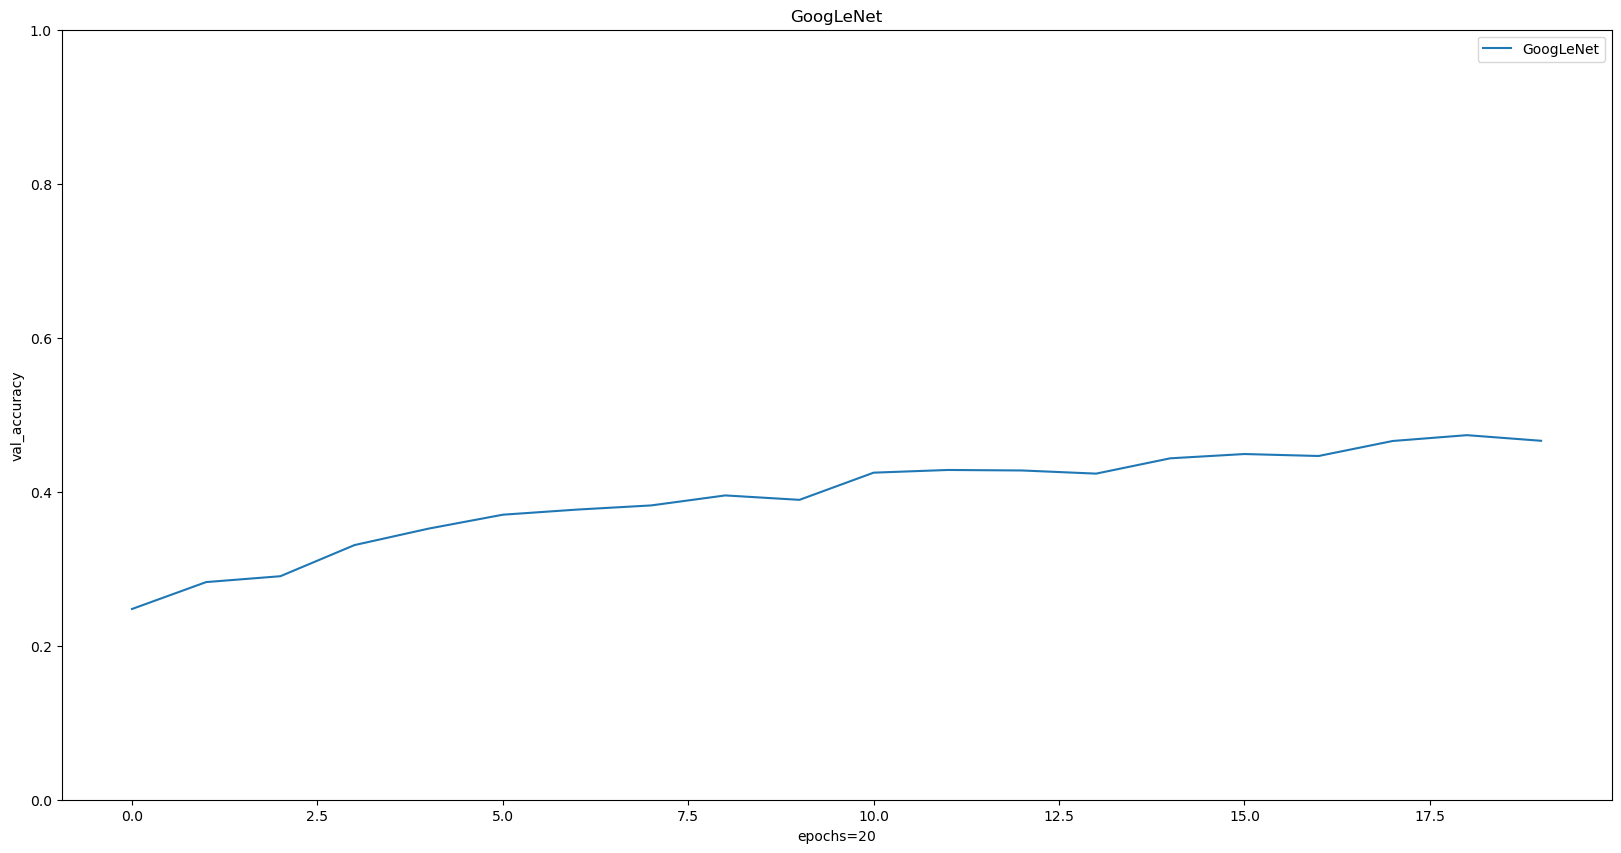

In [129]:
plt.figure(figsize=(20,10))
# plt.plot(hist1.history['val_loss'], label='val_loss1')
# plt.plot(hist2.history['val_loss'], label='val_loss2')
# plt.plot(hist3.history['val_loss'], label='val_loss3')
# plt.plot(hist4.history['val_loss'], label='val_loss4')
plt.plot(hist4.history['val_acc'], label='GoogLeNet')
# plt.plot(hist4.history['val_acc'], label='ESK')
# plt.plot(hist1.history['val_accuracy'], label='Flatten, 2hd')
# plt.plot(hist2.history['val_accuracy'], label='Flatten, 3hd')
# plt.plot(hist3.history['val_accuracy'], label='Flatten, 4hd')
# plt.plot(hist4.history['val_accuracy'], label='Conv2D')
# plt.plot(hist5.history['val_accuracy'], label='Conv2D_2')
plt.ylim(0, 1)
plt.title("GoogLeNet")
plt.ylabel("val_accuracy")
plt.xlabel("epochs=20")
plt.legend()
